### 1) SageMaker Studio dependencies
if you're not using SageMaker Studio, you can ignore this step and build the container manually. But remember to create an ECR repo and push the image. SageMaker depends on ECR

# SageMaker Processing Jobs - OpenGL Synthetic data generation
## With GPU

**SageMaker Studio Kernel: Data Science**

In this exercise you'll learn how to create a custom Docker container capable of running OpenGL applications that require an X Server to render images. Then, using this container you'll be able to run an OpenGL application and export each frame to a new image. To save space and reduce the number of images to upload to S3 later, we'll create mosaics of .jpeg files that can later be loaded by your ML training code.

The container runs an accelerated OpenGL context powered by a GPU. This makes it faster to generate complex rederings. For simple scenes, maybe a CPU based context will run faster.

In [ ]:
# https://github.com/aws-samples/sagemaker-studio-image-build-cli
%pip install sagemaker-studio-image-build

### 2) Create the Dockerfile and a bash script for the entrypoint
The entrypoint is necessary to get some utilitaries from the Nvidia driver package. SageMaker overrides the driver during the execution. The files are read-only, so the entrypoint will only add some new files. Also, it will run Xorg in background to allow the application to open a true OpenGL context/window to render the scene.

In [ ]:
import os
if not os.path.isdir('container_gpu'): os.mkdir('container_gpu')
if not os.path.isdir('src'): os.mkdir('src')

In [ ]:
%%writefile container_gpu/Dockerfile
FROM nvcr.io/nvidia/cudagl:11.2.2-runtime-ubuntu20.04

# Reference: https://github.com/ehfd

# Make all NVIDIA GPUs visible
ARG NVIDIA_VISIBLE_DEVICES=all
ARG DEBIAN_FRONTEND=noninteractive

ENV TZ UTC
ENV LANG=C.UTF-8
ENV LC_ALL=C.UTF-8
ENV NVIDIA_DRIVER_CAPABILITIES all
ENV DISPLAY :0
ENV XDG_RUNTIME_DIR /tmp
ENV SIZEW 1920
ENV SIZEH 1080
ENV REFRESH 60
ENV DPI 96
ENV CDEPTH 24
ENV VIDEO_PORT DFP

ENV PYTHONDONTWRITEBYTECODE=1
ENV PYTHONUNBUFFERED=1
ENV PYTHONIOENCODING=UTF-8

# Install Xorg and others
RUN apt update && apt install -y \
    build-essential ca-certificates \
    kmod libc6 libc6-dev curl file wget \
    bzip2 gzip zip unzip zstd git \
    python3 python3-opencv python3-opengl python3-pip python3-numpy \
    mesa-utils libglu1 libsm6 libxv1 libxtst6 freeglut3-dev \
    xdg-utils x11-xkb-utils x11-xserver-utils x11-utils dbus-x11 \
    libdbus-c++-1-0v5 xauth xinit libxrandr-dev xorg whoopsie \
    && rm -rf /var/lib/apt/lists/*

# If you need additional packages uncomment the following lines
#RUN apt update && apt install -y \
#    <<YOUR PACKAGES HERE>>
#    && rm -rf /var/lib/apt/lists/*

COPY entrypoint.sh /entrypoint.sh
RUN chmod 755 /entrypoint.sh

ENTRYPOINT [ "/entrypoint.sh"]

In [ ]:
%%writefile container_gpu/entrypoint.sh
#!/bin/bash -e

rm -rf /tmp/.X*

ln -snf "/usr/share/zoneinfo/$TZ" /etc/localtime && echo "$TZ" | tee /etc/timezone > /dev/null
ln -snf /dev/ptmx /dev/tty7

echo "1 - Initializing DBUS"
/etc/init.d/dbus start

echo "2 - Installing Nvidia drivers. It will take a few seconds."
# Install NVIDIA drivers including X graphic drivers
export DRIVER_VERSION=$(head -n1 </proc/driver/nvidia/version | awk '{print $8}')
cd /tmp
if [ ! -f "/tmp/NVIDIA-Linux-x86_64-$DRIVER_VERSION.run" ]; then
  curl -fsL -O "https://us.download.nvidia.com/XFree86/Linux-x86_64/$DRIVER_VERSION/NVIDIA-Linux-x86_64-$DRIVER_VERSION.run" || curl -fsL -O "https://us.download.nvidia.com/tesla/$DRIVER_VERSION/NVIDIA-Linux-x86_64-$DRIVER_VERSION.run" || { echo "Failed NVIDIA GPU driver download. Exiting."; exit 1; }
fi
sh "NVIDIA-Linux-x86_64-$DRIVER_VERSION.run" -x
cd "NVIDIA-Linux-x86_64-$DRIVER_VERSION"
./nvidia-installer --silent \
                  --no-kernel-module \
                  --install-compat32-libs \
                  --no-nouveau-check \
                  --no-nvidia-modprobe \
                  --no-rpms \
                  --no-backup \
		  --no-check-for-alternate-installs 2>&1 | grep -v "ERROR: \(Unable\|Failed\)"
rm -rf /tmp/NVIDIA* && cd ~

if grep -Fxq "allowed_users=console" /etc/X11/Xwrapper.config; then
  sed -i "s/allowed_users=console/allowed_users=anybody/;$ a needs_root_rights=yes" /etc/X11/Xwrapper.config
fi

if [ -f "/etc/X11/xorg.conf" ]; then
  rm -f "/etc/X11/xorg.conf"
fi

if [ "$NVIDIA_VISIBLE_DEVICES" == "all" ]; then
  export GPU_SELECT=$(nvidia-smi --query-gpu=uuid --format=csv | sed -n 2p)
elif [ -z "$NVIDIA_VISIBLE_DEVICES" ]; then
  export GPU_SELECT=$(nvidia-smi --query-gpu=uuid --format=csv | sed -n 2p)
else
  export GPU_SELECT=$(nvidia-smi --id=$(echo "$NVIDIA_VISIBLE_DEVICES" | cut -d ',' -f1) --query-gpu=uuid --format=csv | sed -n 2p)
  if [ -z "$GPU_SELECT" ]; then
    export GPU_SELECT=$(nvidia-smi --query-gpu=uuid --format=csv | sed -n 2p)
  fi
fi

if [ -z "$GPU_SELECT" ]; then
  echo "No NVIDIA GPUs detected or nvidia-container-toolkit not configured. Exiting."
  exit 1
fi

if [ "${VIDEO_PORT,,}" = "none" ]; then
  export CONNECTED_MONITOR="--use-display-device=None"
else
  export CONNECTED_MONITOR="--connected-monitor=${VIDEO_PORT}"
fi

HEX_ID=$(nvidia-smi --query-gpu=pci.bus_id --id="$GPU_SELECT" --format=csv | sed -n 2p)
IFS=":." ARR_ID=($HEX_ID)
unset IFS
BUS_ID=PCI:$((16#${ARR_ID[1]})):$((16#${ARR_ID[2]})):$((16#${ARR_ID[3]}))
echo "3 - Creating a config file for xorg"
export MODELINE=$(cvt -r "${SIZEW}" "${SIZEH}" "${REFRESH}" | sed -n 2p)
nvidia-xconfig --virtual="${SIZEW}x${SIZEH}" --depth="$CDEPTH" --mode=$(echo "$MODELINE" | awk '{print $2}' | tr -d '"') --allow-empty-initial-configuration --no-probe-all-gpus --busid="$BUS_ID" --no-multigpu --no-sli --no-base-mosaic --only-one-x-screen ${CONNECTED_MONITOR}
sed -i '/Driver\s\+"nvidia"/a\    Option         "ModeValidation" "NoMaxPClkCheck, NoEdidMaxPClkCheck, NoMaxSizeCheck, NoHorizSyncCheck, NoVertRefreshCheck, NoVirtualSizeCheck, NoExtendedGpuCapabilitiesCheck, NoTotalSizeCheck, NoDualLinkDVICheck, NoDisplayPortBandwidthCheck, AllowNon3DVisionModes, AllowNonHDMI3DModes, AllowNonEdidModes, NoEdidHDMI2Check, AllowDpInterlaced"\n    Option         "HardDPMS" "False"' /etc/X11/xorg.conf
sed -i '/Section\s\+"Monitor"/a\    '"$MODELINE" /etc/X11/xorg.conf

export DISPLAY=":0"
export __GL_SYNC_TO_VBLANK="0"
export __NV_PRIME_RENDER_OFFLOAD="1"
echo "4 - Running Xorg"
Xorg vt7 -noreset -novtswitch -sharevts -dpi "${DPI}" +extension "GLX" +extension "RANDR" +extension "RENDER" +extension "MIT-SHM" "${DISPLAY}" &
XORG_PID=$!

# Wait for X11 to start
echo "Waiting for X socket"
until [ -S "/tmp/.X11-unix/X${DISPLAY/:/}" ]; do sleep 1; done
echo "X socket is ready"

echo "5 - Running your command"
$@
echo "6 - Done! killing all processes..."
kill $XORG_PID
/etc/init.d/dbus stop
echo "7 - All good! :)"

### 3) Build the container image on Studio
If you're not using studio, use **docker build** to create the image. This library also creates an ECR repo if needed, and pushes the image to that repo. If you're building the image manually, you need to create an ECR repo first and then push the image before moving forward.

In [ ]:
image_name='sm-processing-opengl-gpu'

In [ ]:
!sm-docker build container_gpu/ --repository $image_name:latest

### 4) Check the sample OpenGL application
This is a Python app that will be executed inside the container. It renders a cube that can be rotated/translated to change the perspective. You can replace it by any other application to generate useful data.

In [ ]:
!pygmentize src/cube.py

### 5) Kick-off the processing job

In [ ]:
import sagemaker
import boto3
from sagemaker.processing import ScriptProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput

sagemaker_session = sagemaker.Session()

account_id = boto3.client('sts').get_caller_identity().get('Account')
region_name = sagemaker_session.boto_session.region_name
bucket = sagemaker_session.default_bucket()

print(f"Bucket: {bucket}\nAWS AccountID: {account_id}\nRegion: {region_name}")

In [ ]:
import time
script_processor = ScriptProcessor(
    base_job_name=f'cube-opengl-{int(time.time()*1000)}',
    image_uri=f'{account_id}.dkr.ecr.{region_name}.amazonaws.com/{image_name}:latest',
    role=sagemaker.get_execution_role(),
    instance_type='ml.g4dn.xlarge',
    instance_count=1,
    max_runtime_in_seconds=60 * 30,
    command=["/entrypoint.sh", "python3"]
)

script_processor.run(
    code='src/cube.py',
    outputs=[
        ProcessingOutput(
            output_name='gen_images', 
            s3_upload_mode='Continuous', 
            destination=f"s3://{bucket}/cube-opengl-gpu/images",
            source='/opt/ml/processing/output'
        )
    ],
    arguments=[ #total of images = num-mosaics * (mosaic-tiles ** 2)
        '--num-mosaics', '100',
        '--mosaic-tiles', '20',
        '--image-size', '400'
    ]
)

### 6) Visualize a mosaic

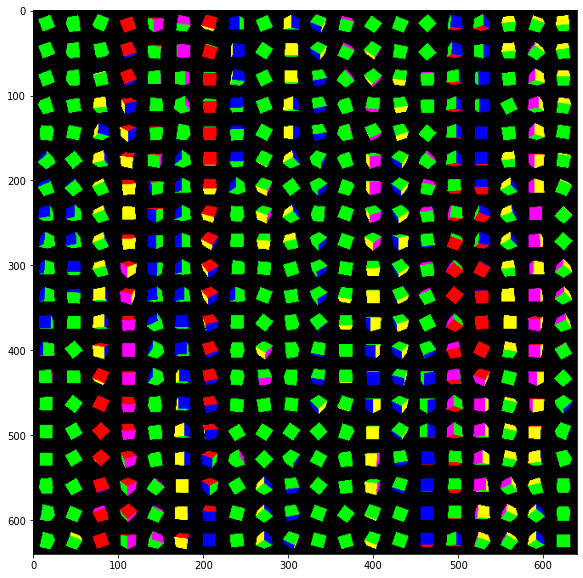

In [12]:
%matplotlib inline
import cv2
import boto3
import numpy as np
import matplotlib.pyplot as plt

s3_client = boto3.client('s3')
num_mosaic=5
data = s3_client.get_object(Bucket=bucket, Key=f"cube-opengl-gpu/images/mosaic_{num_mosaic:015d}.png")['Body'].read()
img = cv2.imdecode(np.frombuffer(data, dtype=np.uint8), cv2.IMREAD_UNCHANGED)
img = cv2.resize(img, (640,640))
plt.figure(figsize=(10,10))
plt.imshow(img)